# Churn Analysis

# **1**

#Importing libraries


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,precision_score,recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
import lime
from lime import lime_tabular
from imblearn.over_sampling import SMOTE

#Loading data

In [92]:
df = pd.read_csv("Churn_treino.csv", sep=";")
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0,1,1,1,10134888,1
1,608,Spain,Female,41,1,8380786,1,0,1,11254258,0
2,502,France,Female,42,8,1596608,3,1,0,11393157,1
3,699,France,Female,39,1,0,2,0,0,9382663,0
4,850,Spain,Female,43,2,12551082,1,1,1,790841,0
5,645,Spain,Male,44,8,11375578,2,1,0,14975671,1
6,822,France,Male,50,7,0,2,1,1,100628,0
7,376,Germany,Female,29,4,11504674,4,1,0,11934688,1
8,501,France,Male,44,4,14205107,2,0,1,749405,0
9,684,France,Male,27,2,13460388,1,1,1,7172573,0


## **2**

#EDA

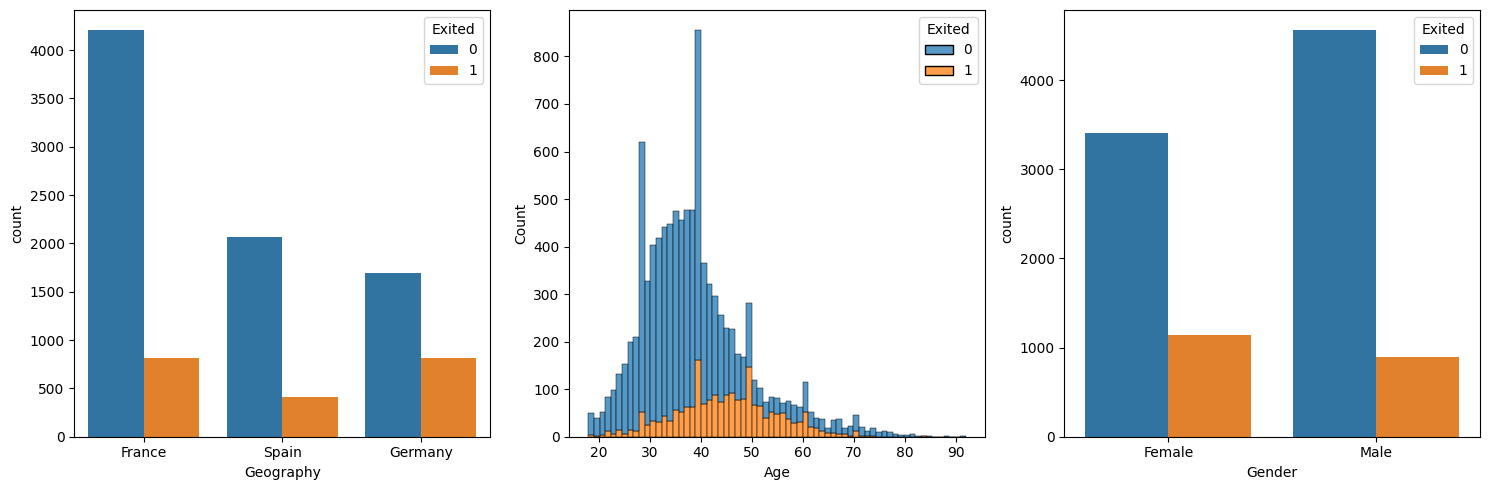

In [93]:
# Distribution of "Exit" (Churn) profile according to Geography, Age, and Gender.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x='Geography', hue='Exited', data=df, ax=ax[0])
sns.histplot(data=df, x='Age', hue='Exited', multiple="stack", ax=ax[1])
sns.countplot(x='Gender', hue='Exited', data=df, ax=ax[2])
plt.tight_layout()
plt.show()

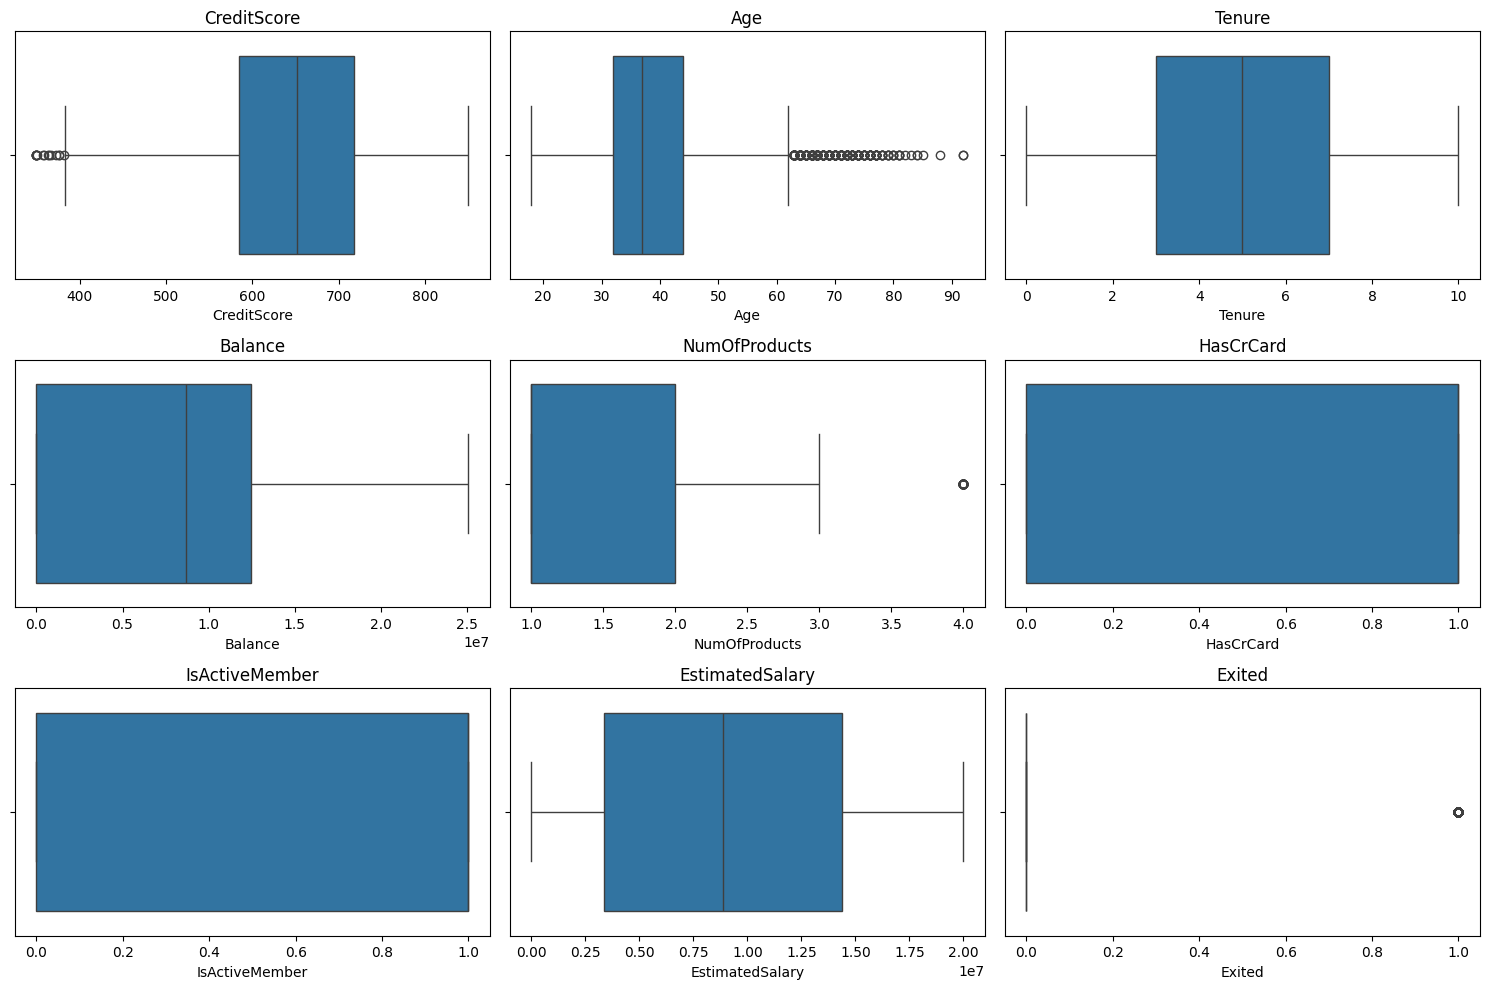

In [94]:
#Checking for outliers using boxplots
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)  # Changed layout to 3 rows and 3 columns
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## **3**

#Data preprocessing

In [95]:
# Check for missing values
print(df.isnull().sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [96]:
# Defining the predictor variables and the target variable
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [97]:
# Splitting the data into training and test sets, with 70% for training and 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardizing numerical variables so they don't contribute disproportionately to the model
standarscaler = StandardScaler()
numerical = X_train.select_dtypes(include=['int64','float64']).columns
X_train[numerical] = standarscaler.fit_transform(X_train[numerical])

# Apply the same scaling to the test set
X_test[numerical] = standarscaler.transform(X_test[numerical])

X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7681,-0.097921,France,Male,-0.557598,-1.036351,-0.856320,0.810394,0.641985,0.966835,-0.563420
9031,-1.126120,France,Male,0.017259,0.697009,-1.088251,0.810394,0.641985,-1.034302,-1.149047
3691,-0.622303,France,Female,3.562216,0.003665,1.465634,-0.929716,-1.557669,0.966835,-1.246306
202,-1.383170,Spain,Male,1.071165,0.003665,-1.088251,-0.929716,-1.557669,0.966835,0.907395
5625,-1.465426,France,Female,2.029262,0.697009,1.184550,-0.929716,0.641985,0.966835,0.637433


In [98]:
# Transforming categorical columns into numerical ones
labelencoder = LabelEncoder()
categorical = X_train.select_dtypes(include='object').columns

for col in categorical:
  X_train[col] = labelencoder.fit_transform(X_train[col])
  # Apply the same encoding to the test set
  X_test[col] = labelencoder.transform(X_test[col])

X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7681,-0.097921,0,1,-0.557598,-1.036351,-0.856320,0.810394,0.641985,0.966835,-0.563420
9031,-1.126120,0,1,0.017259,0.697009,-1.088251,0.810394,0.641985,-1.034302,-1.149047
3691,-0.622303,0,0,3.562216,0.003665,1.465634,-0.929716,-1.557669,0.966835,-1.246306
202,-1.383170,2,1,1.071165,0.003665,-1.088251,-0.929716,-1.557669,0.966835,0.907395
5625,-1.465426,0,0,2.029262,0.697009,1.184550,-0.929716,0.641985,0.966835,0.637433


In [99]:
# Check target variable balance in the training set
print("Target variable balance before oversampling:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

# Apply oversampling with SMOTE on the training set
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check target variable balance after oversampling
print("\nTarget variable balance after oversampling:")
print(y_train_res.value_counts())
print(y_train_res.value_counts(normalize=True))

Target variable balance before oversampling:
Exited
0    5584
1    1416
Name: count, dtype: int64
Exited
0    0.797714
1    0.202286
Name: proportion, dtype: float64

Target variable balance after oversampling:
Exited
1    5584
0    5584
Name: count, dtype: int64
Exited
1    0.5
0    0.5
Name: proportion, dtype: float64


# **4** - **Models**

##Logistic Regression Model as the baseline model

In [100]:
# Creating the Logistic Regression model
model_logistico = LogisticRegression(random_state=0)

# Training the model with the training data
model_logistico.fit(X_train, y_train)

# Making predictions with the test data
y_pred_logistico = model_logistico.predict(X_test)

# Calculating metrics for the Logistic Regression model
metrics_logistico = {
    'Accuracy': accuracy_score(y_test, y_pred_logistico),
    'F1-Score': f1_score(y_test, y_pred_logistico),
    'Precision': precision_score(y_test, y_pred_logistico),
    'Recall': recall_score(y_test, y_pred_logistico)
}

print("\nEvaluation Metrics for Logistic Regression")
for metric, value in metrics_logistico.items():
  print(f"{metric}: {value}")


Evaluation Metrics for Logistic Regression
Accuracy: 0.8033333333333333
F1-Score: 0.26616915422885573
Precision: 0.5846994535519126
Recall: 0.1723027375201288


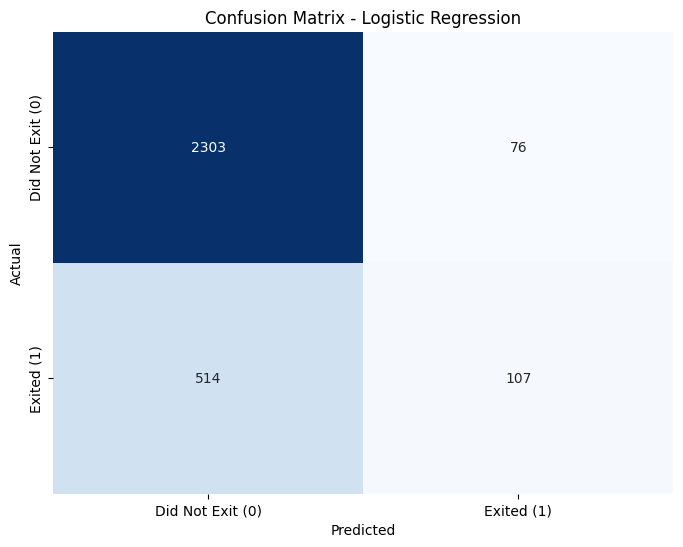

In [101]:
# Generating the confusion matrix for the Logistic Regression model
cm_logistic = confusion_matrix(y_test, y_pred_logistico)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#Neural Networks Model

In [102]:
model = Sequential([                     # Create a sequential model (layers stacked in order).
    Input(shape=(X_train.shape[1],)),    # Define the input shape (number of columns in X_train).
    Dense(units=64, activation='relu'),   # First dense layer with 64 neurons and ReLU activation.
    Dropout(0.4),                         # Randomly "turn off" 40% of neurons in this layer (regularization).
    Dense(units=32, activation='relu'),   # Second dense layer with 32 neurons and ReLU activation.
    Dropout(0.4),                         # Another 40% dropout to prevent overfitting.
    Dense(units=64, activation='relu'),   # Third dense layer with 64 neurons and ReLU activation.
    Dropout(0.4),                         # Dropout again with a 40% rate.
    Dense(units=1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation (for binary classification).
])

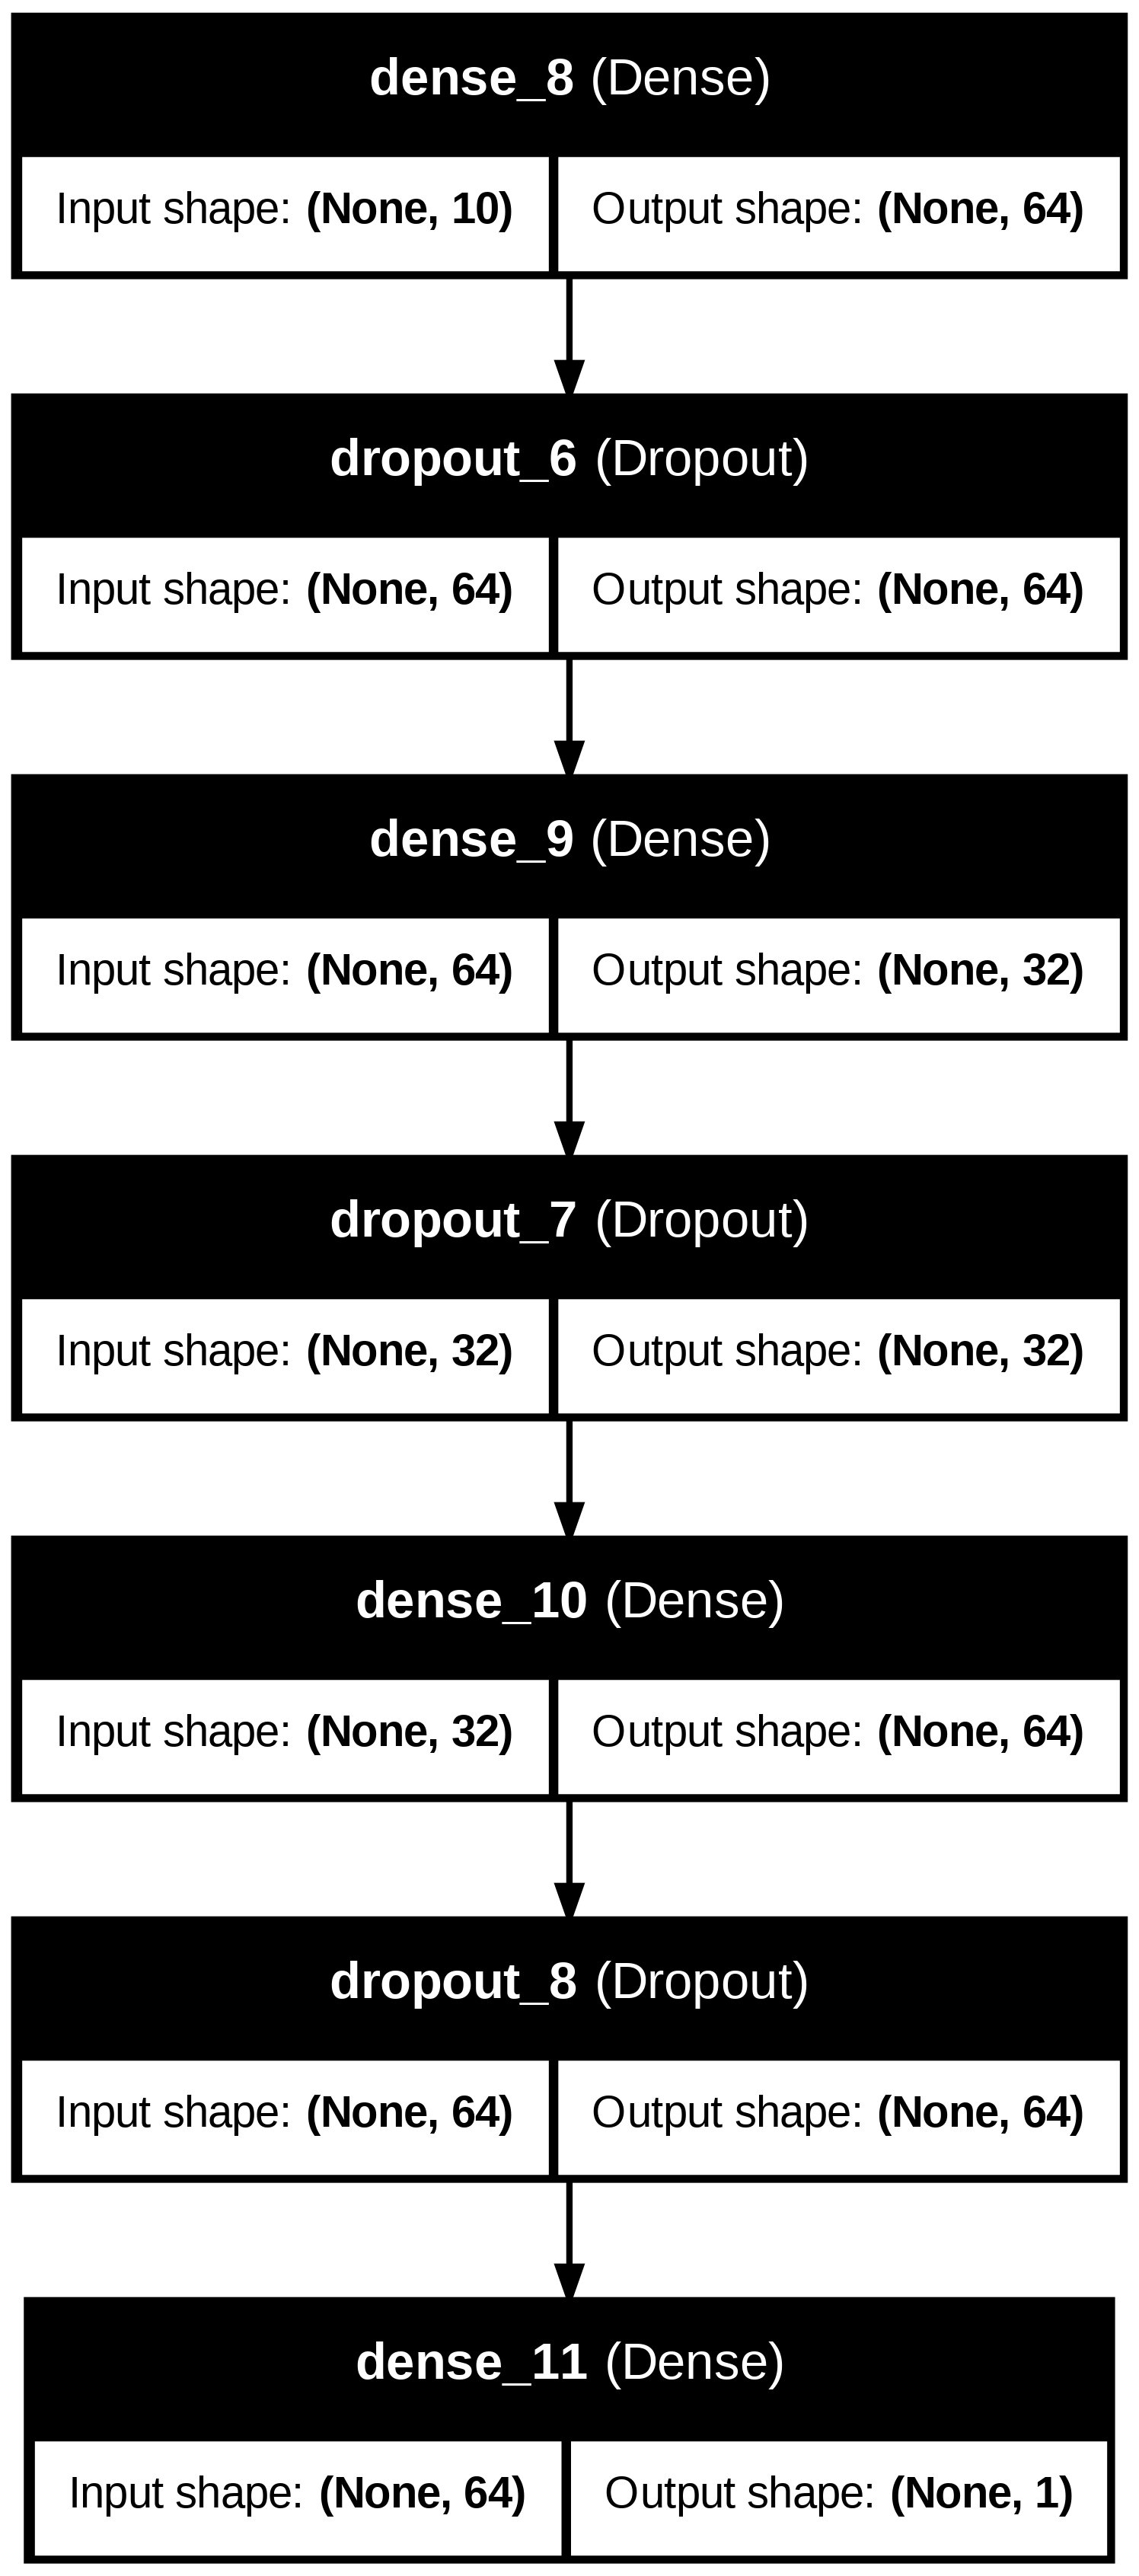

In [103]:
plot_model(model, to_file="modelo.png", show_shapes=True, show_layer_names=True, dpi=300)


#Training

In [104]:
# Training the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7452 - loss: 0.5678
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7999 - loss: 0.4680
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8035 - loss: 0.4456
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8044 - loss: 0.4449
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8190 - loss: 0.4209
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8202 - loss: 0.4158
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8249 - loss: 0.4019
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8264 - loss: 0.3996
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8324 - loss: 0.3949
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8308 - loss: 0.3992
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8351 - loss: 0.3948
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━

#Predictions

In [105]:
predictions = model.predict(X_test)
predictions

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


array([[0.24178   ],
       [0.27035788],
       [0.1100515 ],
       ...,
       [0.0441005 ],
       [0.10854671],
       [0.629137  ]], dtype=float32)

In [106]:
y_pred = (predictions > 0.5).astype('int32')  # Convert predictions to 0 or 1: values > 0.5 become 1, otherwise 0
y_pred                                      # Display the binary predicted values (final classes)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=int32)

#Metrics

In [107]:
# Dictionary with model metrics

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
}
print("Evaluation Metrics")
for metric, value in metrics.items():
  print(f"{metric}: {value}")

Evaluation Metrics
Accuracy: 0.8533333333333334
F1-Score: 0.5880149812734082
Precision: 0.7024608501118568
Recall: 0.5056360708534622


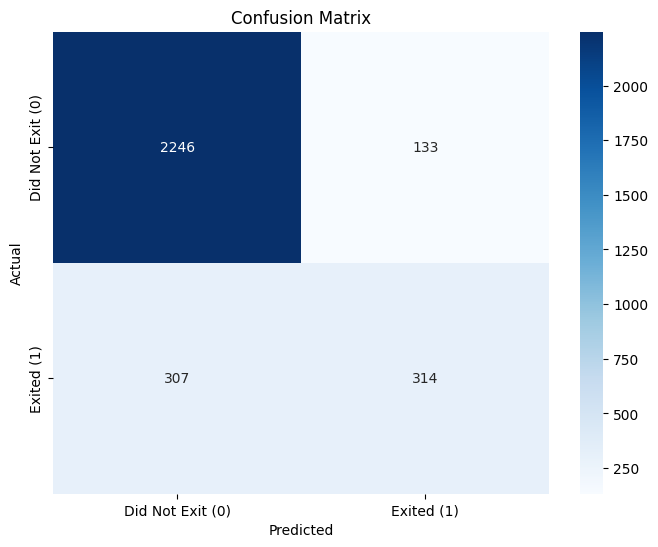

In [108]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [109]:
# Creating the Random Forest model
model_rf = RandomForestClassifier(random_state=0)

# Training the model with the training data
model_rf.fit(X_train, y_train)

# Making predictions with the test data
y_pred_rf = model_rf.predict(X_test)

# Calculating metrics for the Random Forest model
metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf)
}

print("\nEvaluation Metrics for Random Forest")
for metric, value in metrics_rf.items():
  print(f"{metric}: {value}")


Evaluation Metrics for Random Forest
Accuracy: 0.8613333333333333
F1-Score: 0.59375
Precision: 0.7543424317617866
Recall: 0.4895330112721417


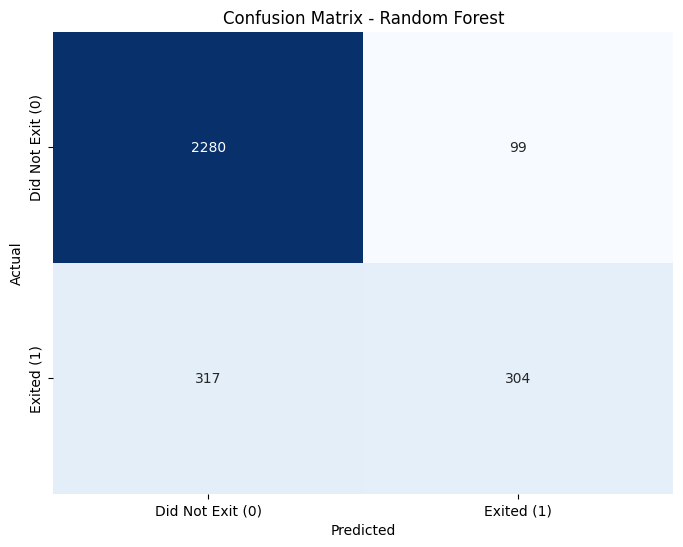

In [110]:
# Generating the confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

#Naive Bayes

In [111]:
# Creating the Naive Bayes model (GaussianNB for numerical data)
model_nb = GaussianNB()

# Training the model with the training data
model_nb.fit(X_train, y_train)

# Making predictions with the test data
y_pred_nb = model_nb.predict(X_test)

# Calculating metrics for the Naive Bayes model
metrics_nb = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1-Score': f1_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb)
}

print("\nEvaluation Metrics for Naive Bayes")
for metric, value in metrics_nb.items():
  print(f"{metric}: {value}")


Evaluation Metrics for Naive Bayes
Accuracy: 0.822
F1-Score: 0.3657957244655582
Precision: 0.6968325791855203
Recall: 0.24798711755233493


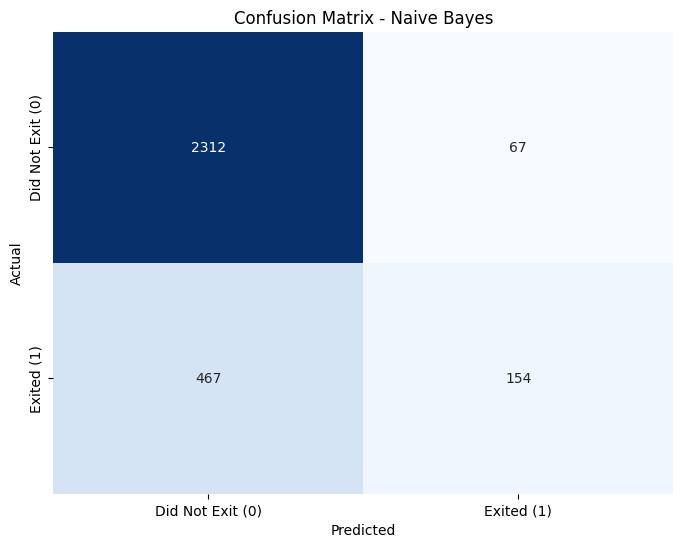

In [112]:
# Generating the confusion matrix for the Naive Bayes model
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

#SVM

In [113]:
# Creating the SVM (Support Vector Machine) model
model_svm = SVC(random_state=0)

# Training the model with the training data
model_svm.fit(X_train, y_train)

# Making predictions with the test data
y_pred_svm = model_svm.predict(X_test)

# Calculating metrics for the SVM model
metrics_svm = {
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1-Score': f1_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm)
}

print("\nEvaluation Metrics for SVM")
for metric, value in metrics_svm.items():
  print(f"{metric}: {value}")


Evaluation Metrics for SVM
Accuracy: 0.863
F1-Score: 0.5575888051668461
Precision: 0.8409090909090909
Recall: 0.4170692431561997


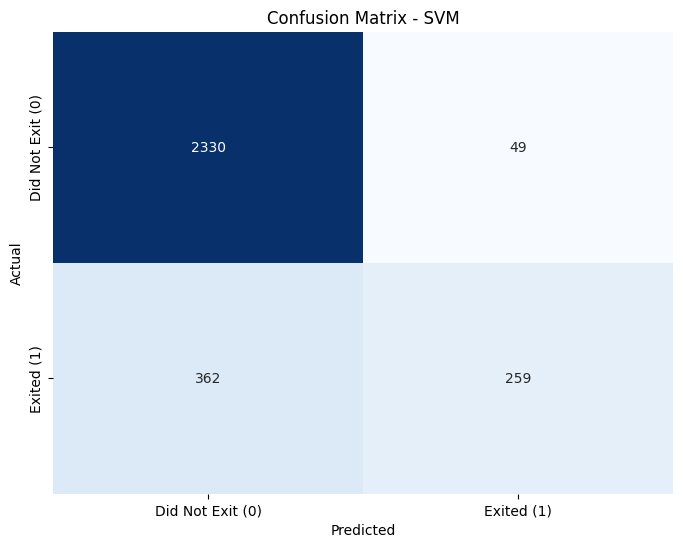

In [114]:
# Generating the confusion matrix for the SVM model
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

#AdaBoost

In [115]:
# Creating the AdaBoost model
model_ada = AdaBoostClassifier(random_state=0)

# Training the model with the training data
model_ada.fit(X_train, y_train)

# Making predictions with the test data
y_pred_ada = model_ada.predict(X_test)

# Calculating metrics for the AdaBoost model
metrics_ada = {
    'Accuracy': accuracy_score(y_test, y_pred_ada),
    'F1-Score': f1_score(y_test, y_pred_ada),
    'Precision': precision_score(y_test, y_pred_ada),
    'Recall': recall_score(y_test, y_pred_ada)
}

print("\nEvaluation Metrics for AdaBoost")
for metric, value in metrics_ada.items():
  print(f"{metric}: {value}")


Evaluation Metrics for AdaBoost
Accuracy: 0.856
F1-Score: 0.5877862595419847
Precision: 0.7213114754098361
Recall: 0.49597423510466987


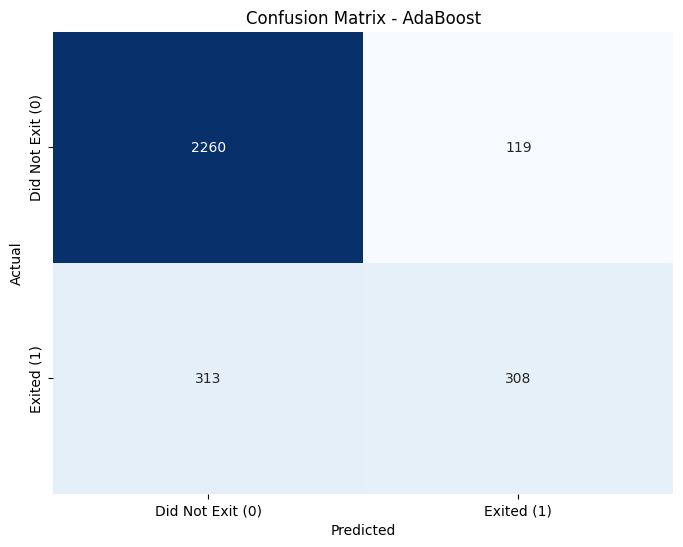

In [116]:
# Generating the confusion matrix for the AdaBoost model
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

#XGBoost

In [117]:
# Creating the XGBoost model
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# Training the model with the training data
model_xgb.fit(X_train, y_train)

# Making predictions with the test data
y_pred_xgb = model_xgb.predict(X_test)

# Calculating metrics for the XGBoost model
metrics_xgb = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb)
}

print("\nEvaluation Metrics for XGBoost")
for metric, value in metrics_xgb.items():
  print(f"{metric}: {value}")


Evaluation Metrics for XGBoost
Accuracy: 0.8543333333333333
F1-Score: 0.5949953660797034
Precision: 0.7008733624454149
Recall: 0.5169082125603864


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:42:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


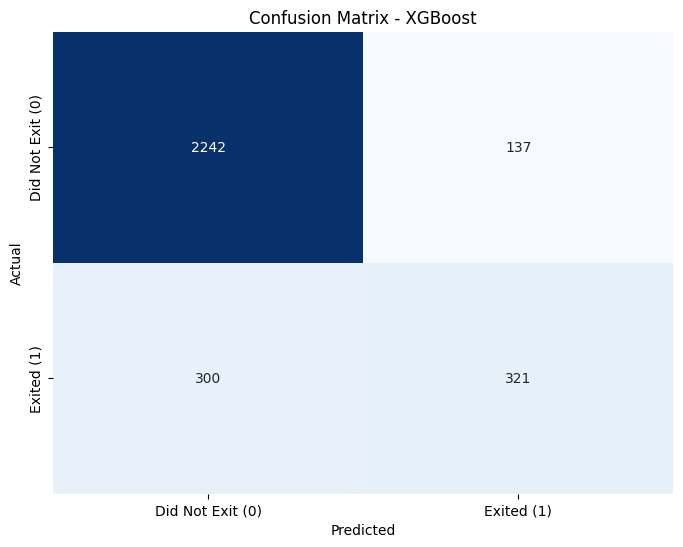

In [118]:
# Generating the confusion matrix for the XGBoost model
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

#KNN

In [119]:
# Creating the KNN model
# NOTE: we can experiment with different values for n_neighbors (the number of neighbors)
model_knn = KNeighborsClassifier(n_neighbors=5)

# Training the model with the training data
model_knn.fit(X_train, y_train)

# Making predictions with the test data
y_pred_knn = model_knn.predict(X_test)

# Calculating metrics for the KNN model
metrics_knn = {
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'F1-Score': f1_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn)
}

print("\nEvaluation Metrics for KNN")
for metric, value in metrics_knn.items():
  print(f"{metric}: {value}")


Evaluation Metrics for KNN
Accuracy: 0.8243333333333334
F1-Score: 0.48585365853658535
Precision: 0.6163366336633663
Recall: 0.40096618357487923


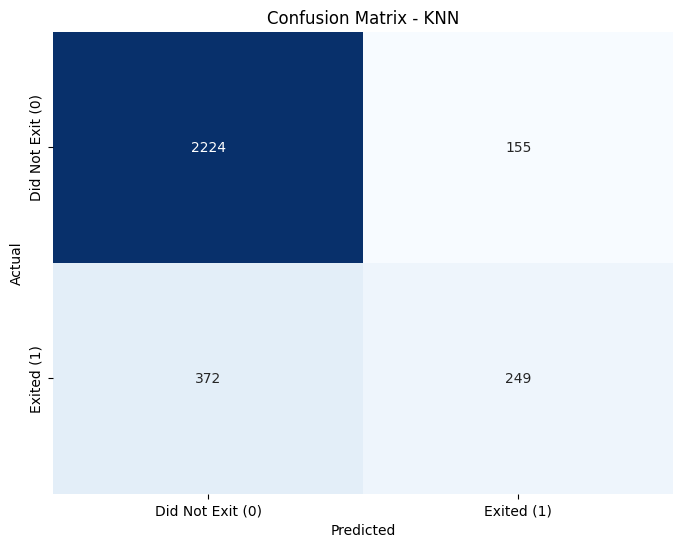

In [120]:
# Generating the confusion matrix for the KNN model
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

#LightGBM

In [121]:
# Creating the LightGBM model
model_lgbm = lgb.LGBMClassifier(random_state=0)

# Training the model with the training data
model_lgbm.fit(X_train, y_train)

# Making predictions with the test data
y_pred_lgbm = model_lgbm.predict(X_test)

# Calculating metrics for the LightGBM model
metrics_lgbm = {
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'F1-Score': f1_score(y_test, y_pred_lgbm),
    'Precision': precision_score(y_test, y_pred_lgbm),
    'Recall': recall_score(y_test, y_pred_lgbm)
}

print("\nEvaluation Metrics for LightGBM")
for metric, value in metrics_lgbm.items():
  print(f"{metric}: {value}")

[LightGBM] [Info] Number of positive: 1416, number of negative: 5584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202286 -> initscore=-1.372069
[LightGBM] [Info] Start training from score -1.372069

Evaluation Metrics for LightGBM
Accuracy: 0.8596666666666667
F1-Score: 0.6090993500464252
Precision: 0.7192982456140351
Recall: 0.5281803542673108


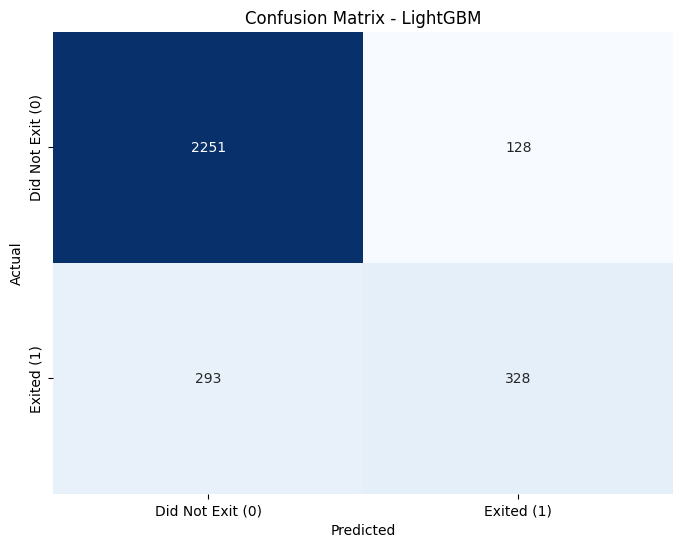

In [122]:
# Generating the confusion matrix for the LightGBM model
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Exit (0)', 'Exited (1)'], yticklabels=['Did Not Exit (0)', 'Exited (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM')
plt.show()

#Metrics comparison table for the models

In [123]:
# Grouping the metrics into a DataFrame
metricas_agrupadas = pd.DataFrame({
    'Neural Network': metrics,
    'Logistic Regression': metrics_logistico,
    'Random Forest': metrics_rf,
    'Naive Bayes': metrics_nb,
    'SVM': metrics_svm,
    'AdaBoost': metrics_ada,
    'XGBoost': metrics_xgb,
    'KNN': metrics_knn,
    'LightGBM': metrics_lgbm
})

print("\nComparative Table of Model Metrics:")
metricas_agrupadas


Comparative Table of Model Metrics:


,Neural Network,Logistic Regression,Random Forest,Naive Bayes,SVM,AdaBoost,XGBoost,KNN,LightGBM
Accuracy,0.853333,0.803333,0.861333,0.822000,0.863000,0.856000,0.854333,0.824333,0.859667
F1-Score,0.588015,0.266169,0.593750,0.365796,0.557589,0.587786,0.594995,0.485854,0.609099
Precision,0.702461,0.584699,0.754342,0.696833,0.840909,0.721311,0.700873,0.616337,0.719298
Recall,0.505636,0.172303,0.489533,0.247987,0.417069,0.495974,0.516908,0.400966,0.528180


# **5**

#Explainability of the best model using LIME


In [124]:
# LIME
# Creating the LIME explainer
# We pass the model we want to explain, the training data, and the column names
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Did Not Exit', 'Exited'],
    mode='classification'
)

# Choose an instance to explain (e.g., the first instance from the test set)
instance_idx = 0
instance = X_test.iloc[instance_idx]

# Getting the explanation for the chosen instance
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=model_lgbm.predict_proba,
    num_features=len(X_test.columns) # Number of features to show in the explanation
)

# Visualizing the explanation
print(f"\nLIME Explanation for instance {instance_idx}:")
explanation.show_in_notebook(show_table=True, show_all=False)


LIME Explanation for instance 0:


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

## **6**

#Financial Impact of the model

In [125]:
# Assuming a hypothetical average revenue per customer value (in Euros €)
average_revenue_per_customer = 100

# Getting the values from the LightGBM confusion matrix
# cm_lgbm[0, 0] is True Negative (TN): Customers who did not churn and were predicted as not churning
# cm_lgbm[0, 1] is False Positive (FP): Customers who did not churn and were predicted as churning
# cm_lgbm[1, 0] is False Negative (FN): Customers who churned and were predicted as not churning
# cm_lgbm[1, 1] is True Positive (TP): Customers who churned and were predicted as churning

tn_lgbm = cm_lgbm[0, 0]
fp_lgbm = cm_lgbm[0, 1]
fn_lgbm = cm_lgbm[1, 0]
tp_lgbm = cm_lgbm[1, 1]

# Calculating the number of churners the model correctly identified (True Positives)
churners_identificados_lgbm = tp_lgbm

# Calculating the potential savings: True Positives * Average Revenue per Customer
# This is a simplified estimate, as it assumes all TP could be retained
potential_savings_lgbm = churners_identificados_lgbm * average_revenue_per_customer

print(f"Potential Churn Savings with LightGBM (assuming retention of all TP): €{potential_savings_lgbm:.2f}")

Potential Churn Savings with LightGBM (assuming retention of all TP): €32800.00
